In [1]:
import pandas as pd

# GitHub raw URL 목록
urls = [
    '../LCK_Data/comments_with_timeline_1.csv',
    '../LCK_Data/comments_with_timeline_2.csv'
]

dfs = []

for url in urls:
    # 파일 이름만 추출 (예: Round1_Bahrain.csv → Round1_Bahrain)
    filename = url.split("/")[-1].replace(".csv", "")

    # CSV 읽기
    df = pd.read_csv(url)

    dfs.append(df)

# 모든 데이터 합치기
df_all = pd.concat(dfs, ignore_index=True)

In [6]:
df_all.columns

Index(['time', 'timestamp', 'author', 'message', 'format', 'datetime_kst',
       'drake_normal_event', 'voidgrub_event', 'herald_event', 'nashor_event',
       'drake_elder_event', 'kill_event', 'takedown_event', 'nexus_event',
       'kill_streak_event'],
      dtype='object')

In [4]:
# ~event별 개수 확인
print("=== Event Counts ===")
df_all[['drake_normal_event', 'voidgrub_event', 'herald_event', 'nashor_event',
             'drake_elder_event', 'kill_event', 'takedown_event', 'nexus_event','kill_streak_event']].sum()

=== Event Counts ===


drake_normal_event    30653
voidgrub_event        14791
herald_event           6880
nashor_event          12131
drake_elder_event       849
kill_event            87582
takedown_event        26679
nexus_event           17378
kill_streak_event     21429
dtype: int64

In [13]:
# 댓글 간 시간 간격 계산 (timestamp 마이크로초 기반)
# timestamp를 datetime으로 변환 (마이크로초 단위)
df_all['datetime_from_timestamp'] = pd.to_datetime(df_all['timestamp'], unit='us', utc=True)
df_all['datetime_from_timestamp'] = df_all['datetime_from_timestamp'].dt.tz_convert('Asia/Seoul')

# 날짜 추출 (date 컬럼)
df_all['date'] = df_all['datetime_from_timestamp'].dt.date

# date별로 정렬
df_all = df_all.sort_values(['date', 'timestamp']).reset_index(drop=True)

# 같은 date 내에서 이전/다음 댓글과의 시간 차이 계산 (초 단위)
df_all['time_diff_prev'] = df_all.groupby('date')['timestamp'].diff() / 1_000_000  # 마이크로초 → 초
df_all['time_diff_next'] = df_all.groupby('date')['timestamp'].diff(-1).abs() / 1_000_000

# 댓글 간격 계산: 앞뒤 댓글과의 간격 평균
df_all['comment_interval'] = df_all.apply(
    lambda row: (
        row['time_diff_prev'] if pd.isna(row['time_diff_next']) else
        row['time_diff_next'] if pd.isna(row['time_diff_prev']) else
        (row['time_diff_prev'] + row['time_diff_next']) / 2
    ),
    axis=1
)

# 임시 컬럼 제거
df_all = df_all.drop(['time_diff_prev', 'time_diff_next', 'datetime_from_timestamp'], axis=1)

print("=== Comment Interval Statistics (based on timestamp) ===")
print(df_all['comment_interval'].describe())
print(f"\nNull count: {df_all['comment_interval'].isna().sum()}")

=== Comment Interval Statistics (based on timestamp) ===
count    1.520294e+06
mean     1.536306e+00
std      2.153433e+01
min      5.550000e-05
25%      1.853710e-01
50%      4.818575e-01
75%      1.247822e+00
max      5.752937e+03
Name: comment_interval, dtype: float64

Null count: 0


In [17]:
df_all.sample(5)

,time,timestamp,author,message,format,datetime_kst,drake_normal_event,voidgrub_event,herald_event,nashor_event,drake_elder_event,kill_event,takedown_event,nexus_event,kill_streak_event,date,comment_interval
193669,3:03:08,1744972429087630,UCAXj4w2VXNxwvi9e6OHS-Vw,굿바이 구마유시,R1~2,2025-04-18 19:33:49+09:00,0,0,0,0,0,0,0,0,0,2025-04-18,0.270224
282513,1:48:16,1745738336967966,UCDa2L0zzlSWd6UBJmV_tjAQ,와 진짜 존나못싸우네 브리온,R1~2,2025-04-27 16:18:56+09:00,0,0,0,0,0,0,0,0,0,2025-04-27,0.087783
188093,2:37:38,1744970899857651,UC5-HYEU4Qz9CA6FPwUTOMOQ,라인전 벌써 이김ㅋㅋㅋㅋ,R1~2,2025-04-18 19:08:19+09:00,0,0,0,0,0,0,0,0,0,2025-04-18,0.217104
332851,3:41:23,1746183734507153,UCwL8Xmlq1RnI_vmbtm9P0yg,한화생명 파이팅!!!,R1~2,2025-05-02 20:02:14+09:00,0,0,0,0,0,0,0,0,0,2025-05-02,4.634466
1091596,4:36:06,1755690987833080,UC6yeTjpl2NG4xCmmd8AwGZw,말 그대로 압살 그 자체를 보여주네 도발 만개,R3~5,2025-08-20 20:56:27+09:00,1,0,0,0,0,0,0,0,0,2025-08-20,0.973726


In [18]:
# 다중공선성 분석
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("=" * 80)
print("다중공선성 분석 (VIF - Variance Inflation Factor)")
print("=" * 80)
print("VIF 해석:")
print("  1 = 공선성 없음")
print("  1-5 = 약한 공선성")
print("  5-10 = 중간 정도 공선성")
print("  10 이상 = 높은 공선성 (문제 가능성)")
print("\n")
print(vif_data.sort_values('VIF', ascending=False).to_string(index=False))

# 상관관계 행렬
print("\n" + "=" * 80)
print("독립변수 간 상관관계 행렬")
print("=" * 80)
correlation_matrix = X.corr()
print(correlation_matrix.round(3))

다중공선성 분석 (VIF - Variance Inflation Factor)
VIF 해석:
  1 = 공선성 없음
  1-5 = 약한 공선성
  5-10 = 중간 정도 공선성
  10 이상 = 높은 공선성 (문제 가능성)


          Variable      VIF
        kill_event 1.396398
 kill_streak_event 1.330159
    takedown_event 1.086678
       nexus_event 1.003778
drake_normal_event 1.003058
      nashor_event 1.002868
    voidgrub_event 1.001127
 drake_elder_event 1.001054
      herald_event 1.000757

독립변수 간 상관관계 행렬
                    drake_normal_event  voidgrub_event  herald_event  \
drake_normal_event               1.000          -0.002         0.001   
voidgrub_event                  -0.002           1.000        -0.007   
herald_event                     0.001          -0.007         1.000   
nashor_event                    -0.002          -0.009        -0.006   
drake_elder_event               -0.003          -0.002        -0.002   
kill_event                       0.015           0.005         0.007   
takedown_event                   0.014          -0.006         0.009   
ne

In [20]:
# 회귀분석 수행 (formula API 사용)
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 회귀식 작성
formula = 'comment_interval ~ drake_normal_event + voidgrub_event + herald_event + nashor_event + drake_elder_event + kill_event + takedown_event + nexus_event + kill_streak_event'

# OLS 모델 적합
model = ols(formula, data=df_all).fit()

print("=" * 80)
print("회귀분석 결과 (Formula API)")
print("=" * 80)
print(model.summary())

print("\n" + "=" * 80)
print("주요 지표")
print("=" * 80)
print(f"R-squared: {model.rsquared:.6f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.6f}")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4e}")
print(f"AIC: {model.aic:.2f}")
print(f"BIC: {model.bic:.2f}")

# 독립변수 저장 (시각화를 위해)
X = df_all[['drake_normal_event', 'voidgrub_event', 'herald_event', 'nashor_event',
            'drake_elder_event', 'kill_event', 'takedown_event', 'nexus_event', 'kill_streak_event']]
y = df_all['comment_interval']

회귀분석 결과 (Formula API)
                            OLS Regression Results                            
Dep. Variable:       comment_interval   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.59
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.05e-33
Time:                        14:47:32   Log-Likelihood:            -6.8239e+06
No. Observations:             1520294   AIC:                         1.365e+07
Df Residuals:                 1520284   BIC:                         1.365e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept     

C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\1673268748.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([event_no_filtered, event_yes_filtered],
C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\1673268748.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([event_no_filtered, event_yes_filtered],
C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\1673268748.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([event_no_filtered, event_yes_filtered],
C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\1673268748.py:43: MatplotlibDeprecationWarning: The 'labels' p

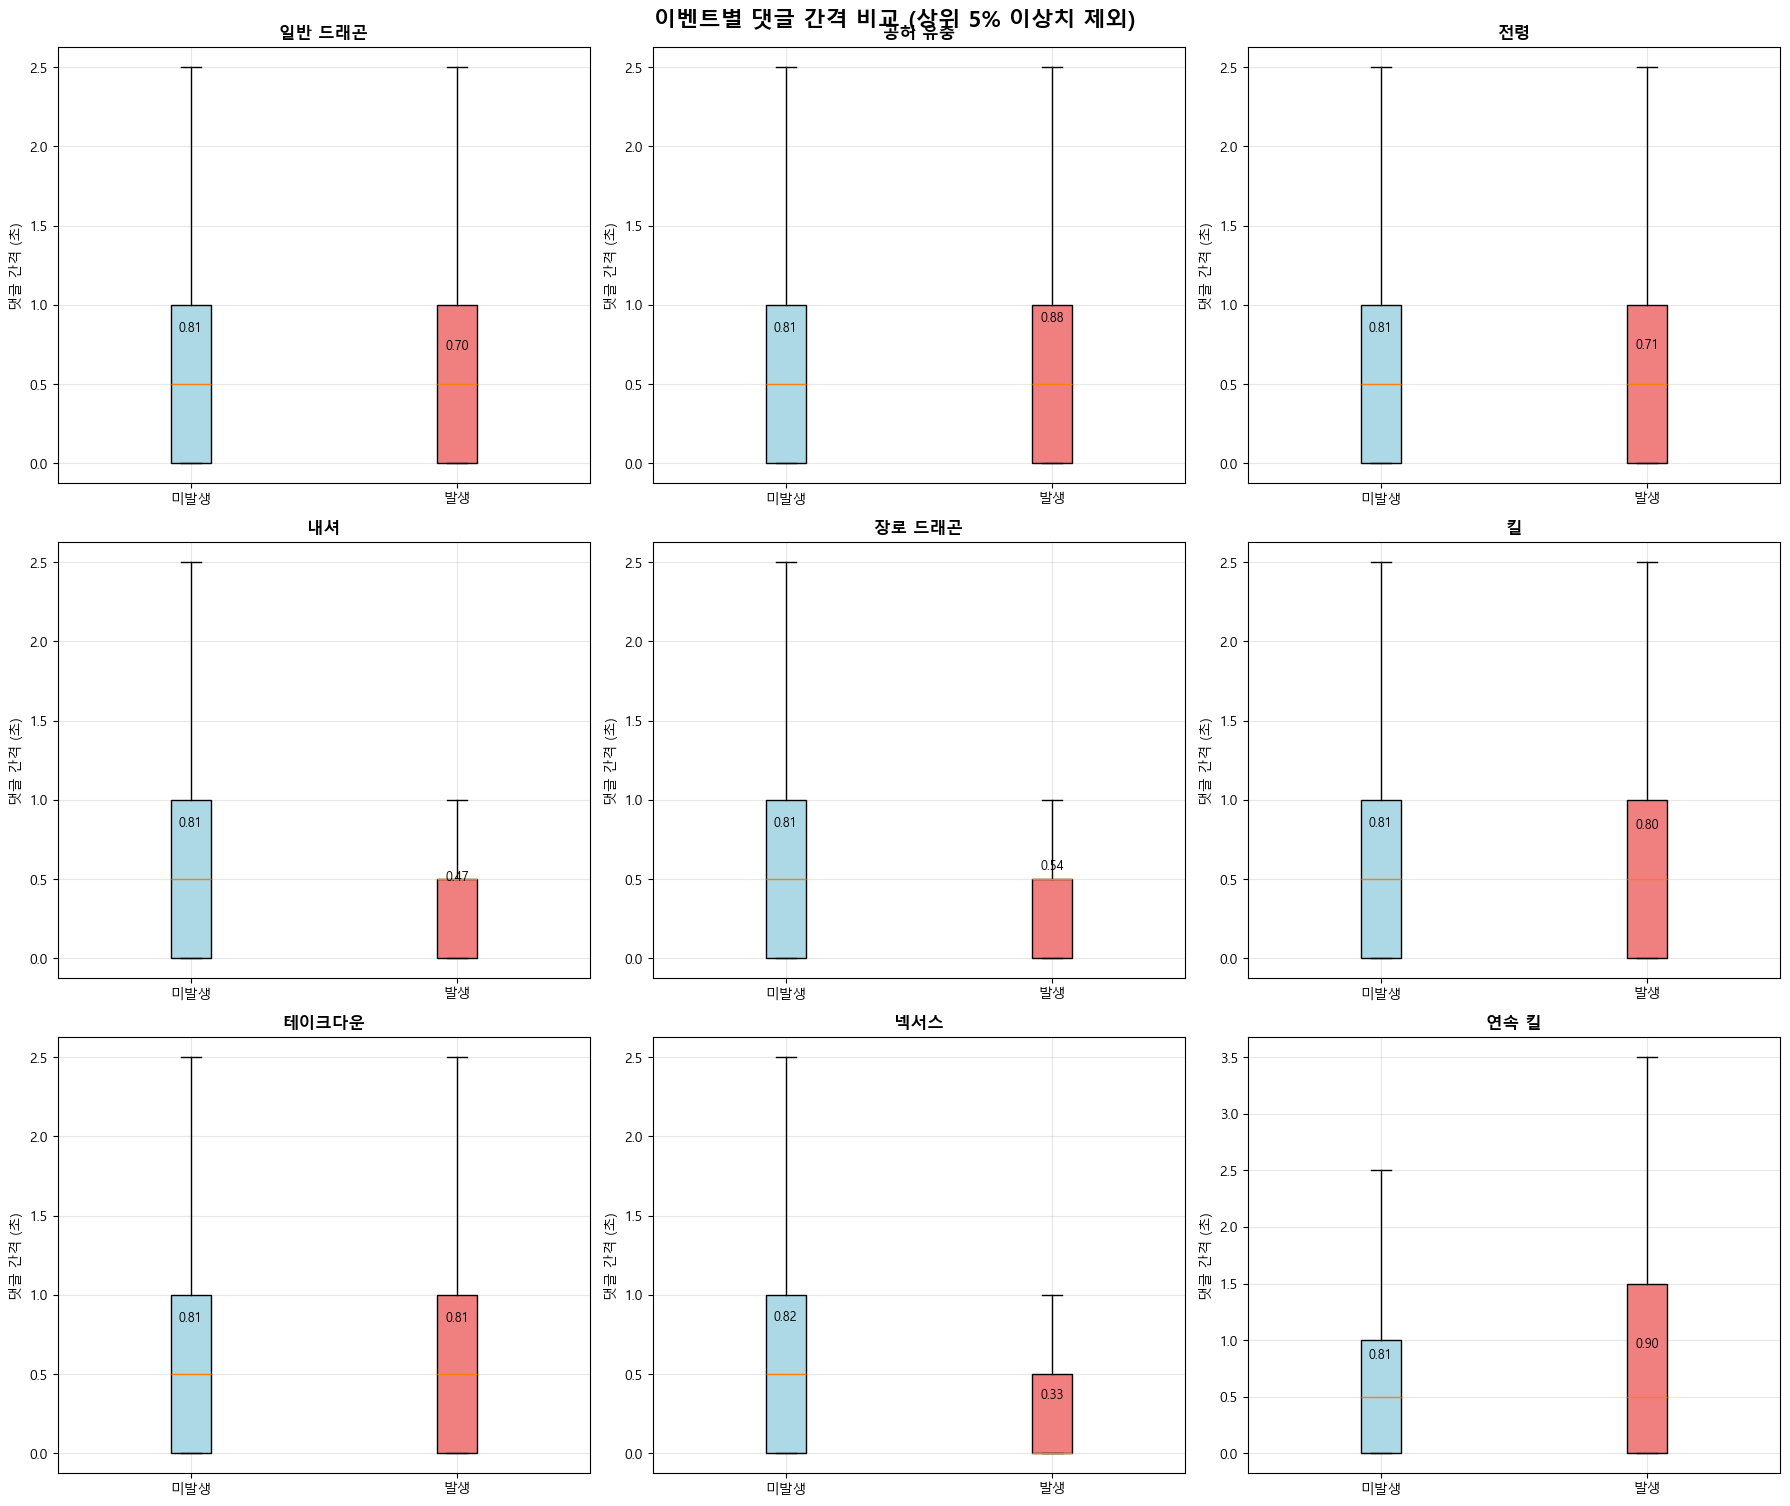

In [5]:
# 이벤트별 댓글 간격 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 이벤트 컬럼 리스트
event_columns = ['drake_normal_event', 'voidgrub_event', 'herald_event', 'nashor_event',
                 'drake_elder_event', 'kill_event', 'takedown_event', 'nexus_event', 'kill_streak_event']

# 이벤트 이름 매핑 (한글)
event_names = {
    'drake_normal_event': '일반 드래곤',
    'voidgrub_event': '공허 유충',
    'herald_event': '전령',
    'nashor_event': '내셔',
    'drake_elder_event': '장로 드래곤',
    'kill_event': '킬',
    'takedown_event': '테이크다운',
    'nexus_event': '넥서스',
    'kill_streak_event': '연속 킬'
}

# 1. 박스플롯: 이벤트 발생 여부에 따른 댓글 간격 비교
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(event_columns):
    ax = axes[idx]
    
    # 이벤트 발생/미발생 데이터 분리
    event_yes = df_all[df_all[col] == 1]['comment_interval']
    event_no = df_all[df_all[col] == 0]['comment_interval']
    
    # 이상치 제거 (상위 5% 제외하여 시각화 개선)
    quantile_95 = df_all['comment_interval'].quantile(0.95)
    event_yes_filtered = event_yes[event_yes <= quantile_95]
    event_no_filtered = event_no[event_no <= quantile_95]
    
    # 박스플롯
    bp = ax.boxplot([event_no_filtered, event_yes_filtered], 
                     labels=['미발생', '발생'],
                     patch_artist=True,
                     showfliers=False)
    
    # 색상 설정
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(f'{event_names[col]}', fontsize=12, fontweight='bold')
    ax.set_ylabel('댓글 간격 (초)', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 평균값 표시
    mean_no = event_no_filtered.mean()
    mean_yes = event_yes_filtered.mean()
    ax.text(1, mean_no, f'{mean_no:.2f}', ha='center', va='bottom', fontsize=9)
    ax.text(2, mean_yes, f'{mean_yes:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('이벤트별 댓글 간격 비교 (상위 5% 이상치 제외)', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\2803830612.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x=col, y='comment_interval', ax=ax, palette=['lightblue', 'lightcoral'])
C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\2803830612.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x=col, y='comment_interval', ax=ax, palette=['lightblue', 'lightcoral'])
C:\Users\qkrwl\AppData\Local\Temp\ipykernel_16656\2803830612.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_data, x=

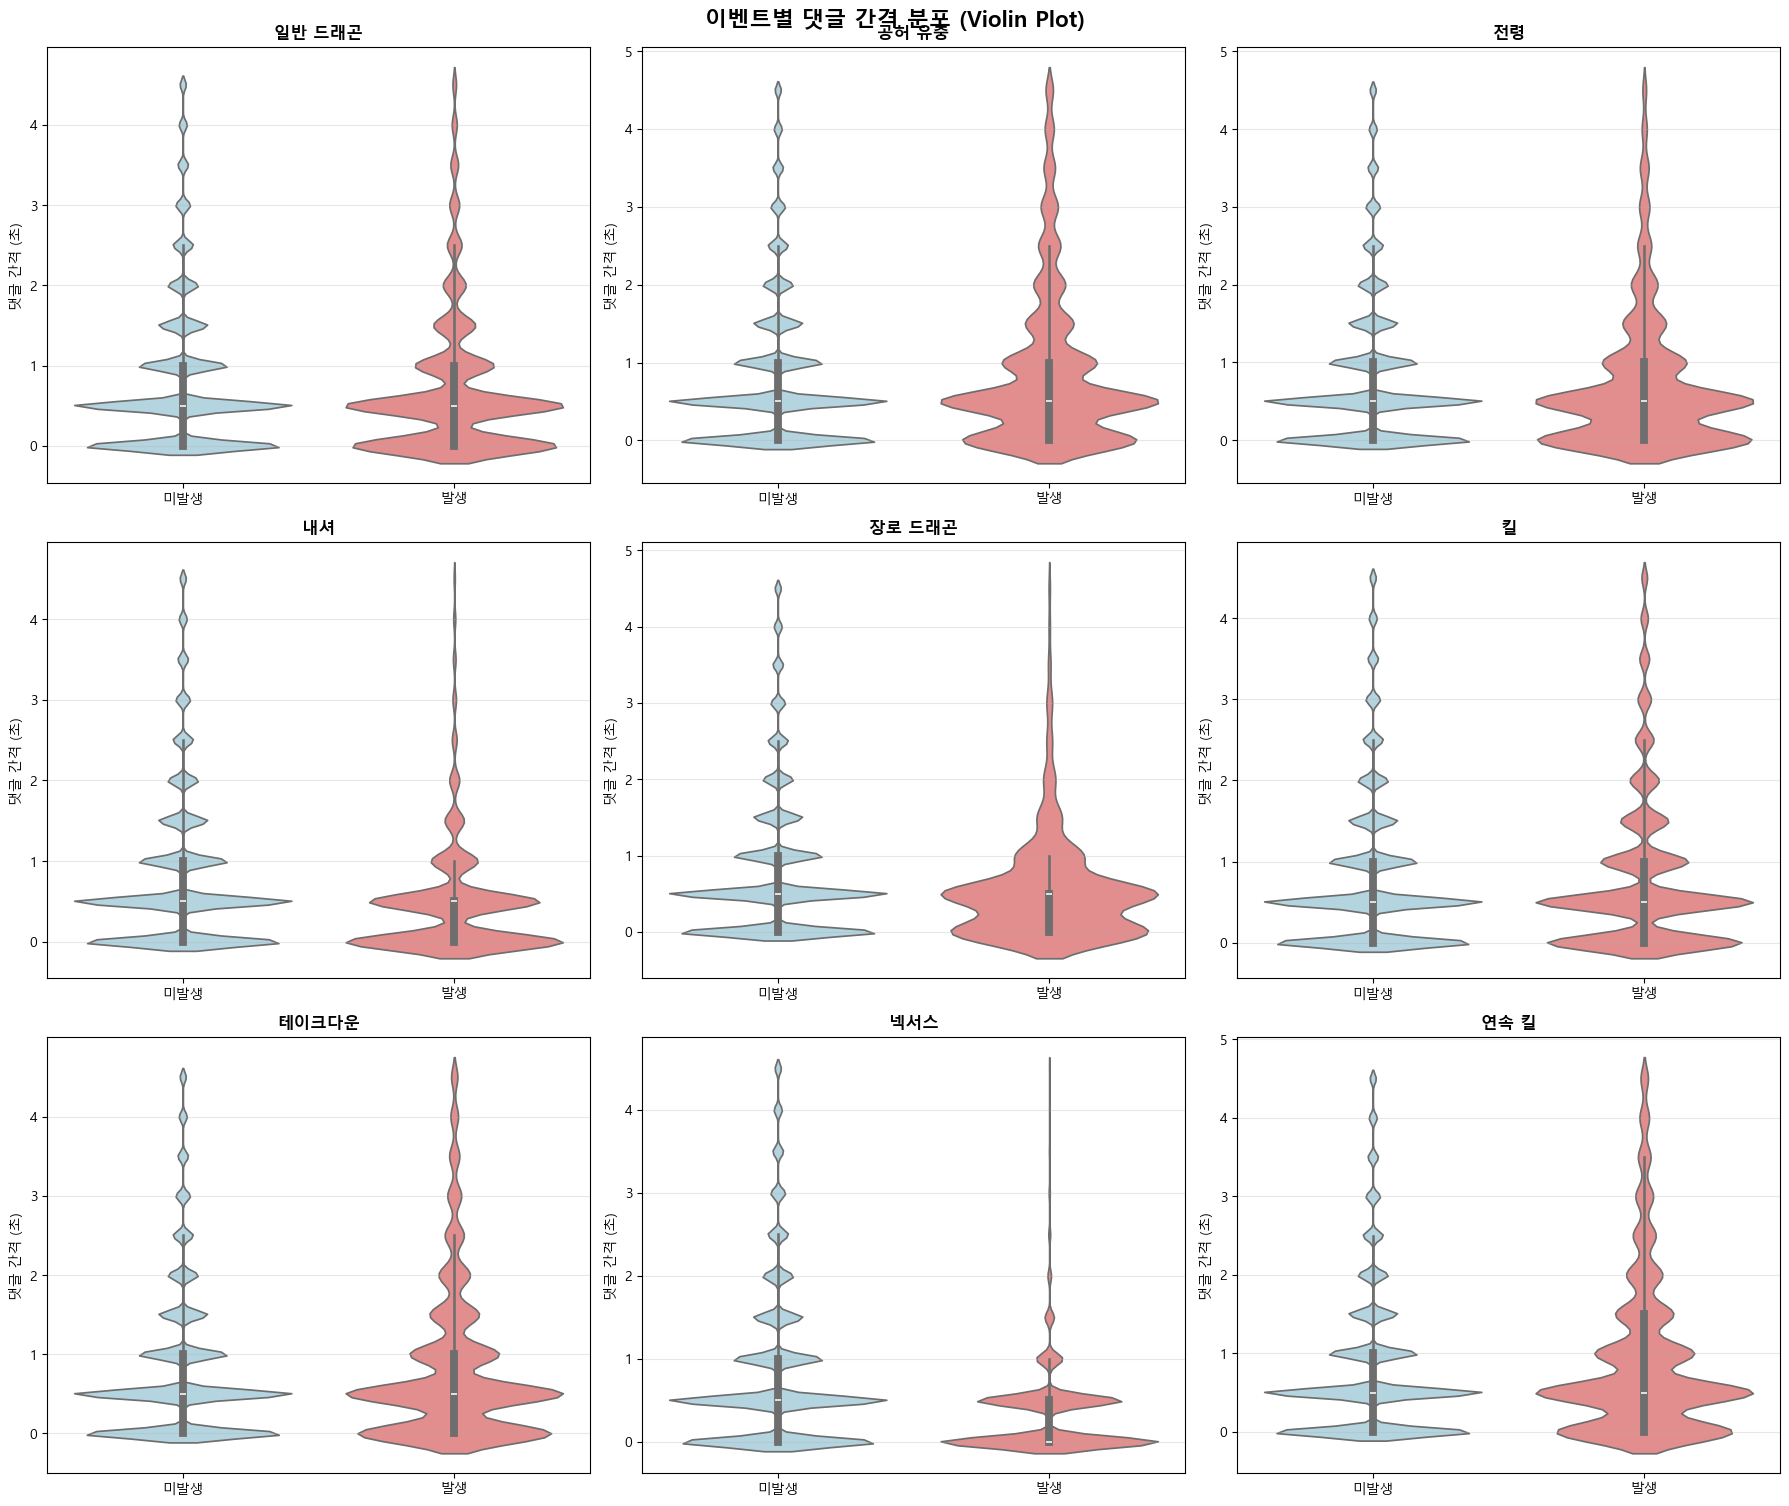

In [6]:
# 2. 바이올린 플롯: 분포 형태 비교
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(event_columns):
    ax = axes[idx]
    
    # 데이터 준비
    plot_data = df_all[[col, 'comment_interval']].copy()
    plot_data[col] = plot_data[col].map({0: '미발생', 1: '발생'})
    
    # 이상치 제거
    quantile_95 = df_all['comment_interval'].quantile(0.95)
    plot_data = plot_data[plot_data['comment_interval'] <= quantile_95]
    
    # 바이올린 플롯
    sns.violinplot(data=plot_data, x=col, y='comment_interval', ax=ax, palette=['lightblue', 'lightcoral'])
    
    ax.set_title(f'{event_names[col]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('댓글 간격 (초)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('이벤트별 댓글 간격 분포 (Violin Plot)', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

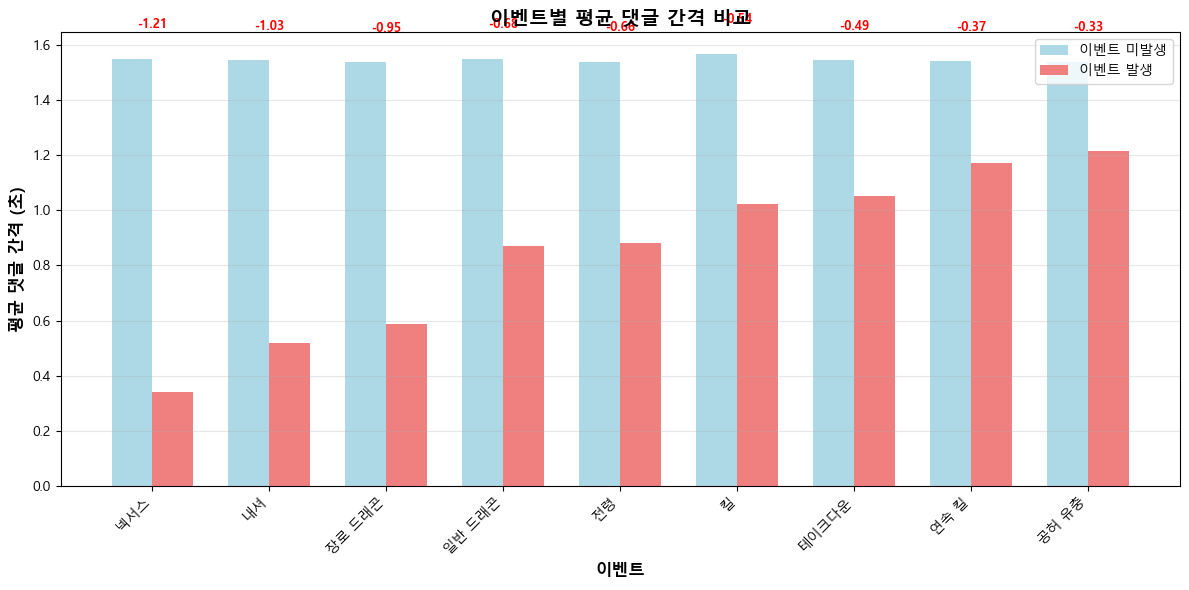

In [10]:
# 3. 평균 댓글 간격 비교 바 차트
fig, ax = plt.subplots(figsize=(12, 6))

means_data = []
for col in event_columns:
    mean_no = df_all[df_all[col] == 0]['comment_interval'].mean()
    mean_yes = df_all[df_all[col] == 1]['comment_interval'].mean()
    diff = mean_yes - mean_no
    means_data.append({
        'event': event_names[col],
        'mean_no': mean_no,
        'mean_yes': mean_yes,
        'diff': diff
    })

means_df = pd.DataFrame(means_data)
means_df = means_df.sort_values('diff')

x = range(len(means_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], means_df['mean_no'], width, label='이벤트 미발생', color='lightblue')
bars2 = ax.bar([i + width/2 for i in x], means_df['mean_yes'], width, label='이벤트 발생', color='lightcoral')

ax.set_xlabel('이벤트', fontsize=12, fontweight='bold')
ax.set_ylabel('평균 댓글 간격 (초)', fontsize=12, fontweight='bold')
ax.set_title('이벤트별 평균 댓글 간격 비교', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(means_df['event'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 차이값 표시
for i, (idx, row) in enumerate(means_df.iterrows()):
    diff = row['diff']
    y_pos = max(row['mean_no'], row['mean_yes']) + 0.1
    color = 'red' if diff < 0 else 'green'
    ax.text(i, y_pos, f'{diff:.2f}', ha='center', va='bottom', fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

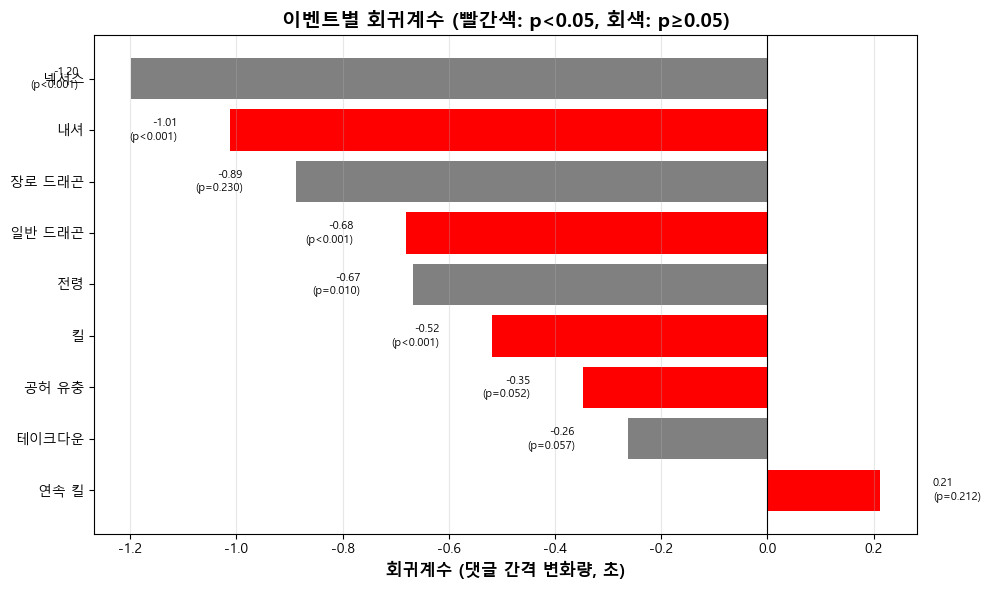

In [11]:
# 4. 회귀계수 시각화 (회귀분석 결과 기반)
fig, ax = plt.subplots(figsize=(10, 6))

# 회귀계수와 p-value 추출 (상수항 제외)
coef_data = pd.DataFrame({
    'event': [event_names[col] for col in event_columns],
    'coefficient': model.params[1:].values,
    'p_value': model.pvalues[1:].values
})

# p-value에 따라 색상 구분
colors = ['red' if p < 0.05 else 'gray' for p in coef_data['p_value']]

# 절댓값 기준으로 정렬
coef_data = coef_data.reindex(coef_data['coefficient'].abs().sort_values(ascending=True).index)

bars = ax.barh(coef_data['event'], coef_data['coefficient'], color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('회귀계수 (댓글 간격 변화량, 초)', fontsize=12, fontweight='bold')
ax.set_title('이벤트별 회귀계수 (빨간색: p<0.05, 회색: p≥0.05)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 계수값 표시
for i, (idx, row) in enumerate(coef_data.iterrows()):
    coef = row['coefficient']
    p_val = row['p_value']
    label = f"{coef:.2f}\n(p={p_val:.3f})" if p_val >= 0.001 else f"{coef:.2f}\n(p<0.001)"
    x_pos = coef + (0.1 if coef > 0 else -0.1)
    ax.text(x_pos, i, label, ha='left' if coef > 0 else 'right', va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
df_all.to_csv('../LCK_Data/comments_with_timeline_and_intervals.csv', index=False)